In [18]:
import numpy as np
import argparse
import time
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
args = {
    'image': '/Users/sumit/Desktop/SUMIT/STUDY/Projects/YOLO/YOLO_image1.jpeg',  # Specify the path to your input image here
    'confidence': 0.5,                  # Set the minimum probability to filter weak detections
    'threshold': 0.3                    # Set the threshold for non-maxima suppression
}


In [21]:
# load the COCO class labels our YOLO model was trained on
labelsPath = 'COCO names.names'
LABELS = open(labelsPath).read().strip().split("\n")
labelsPath


'COCO names.names'

In [4]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [5]:
# derive the paths to the YOLO weights and model configuration
weightsPath = 'yolov3.weights'
configPath = 'yolov3.cfg'

In [6]:
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [7]:
#load our input image and grab its spatial dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

In [8]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
print("All Layer Names:", ln)

try:
    unconnected_out_layers = net.getUnconnectedOutLayers()
    print("Unconnected Output Layers:", unconnected_out_layers)

    # Ensure unconnected_out_layers is a list
    if isinstance(unconnected_out_layers, np.ndarray):  # Check if it's an ndarray
        unconnected_out_layers = unconnected_out_layers.tolist()  # Convert to list if it's an ndarray
    elif not isinstance(unconnected_out_layers, list):
        raise TypeError("Unconnected output layers should be a list.")

    # Extract layer names using list comprehension
    ln = [ln[i - 1] for i in unconnected_out_layers]
    print("Selected Output Layer Names:", ln)

except Exception as e:
    print("An error occurred:", e)


All Layer Names: ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37',

In [9]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
unconnected_out_layers = net.getUnconnectedOutLayers()

# Check if unconnected_out_layers is a list or ndarray
if isinstance(unconnected_out_layers, list):
    ln = [ln[i - 1] for i in unconnected_out_layers]
    print("Selected Output Layer Names:", ln)
elif isinstance(unconnected_out_layers, np.ndarray):
    # Flatten the numpy array if it has more than one dimension
    if unconnected_out_layers.ndim > 1:
        unconnected_out_layers = unconnected_out_layers.flatten()
    ln = [ln[i - 1] for i in unconnected_out_layers]
    print("Selected Output Layer Names:", ln)
else:
    print("Error: Unconnected output layers should be a list or ndarray.")


Selected Output Layer Names: ['yolo_82', 'yolo_94', 'yolo_106']


In [10]:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)

In [11]:
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

In [12]:
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 1.397405 seconds


In [13]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [14]:
for output in layerOutputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        
        if confidence > args["confidence"]:
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

In [15]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
	args["threshold"])

In [16]:
if len(idxs) > 0:
    for i in idxs.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

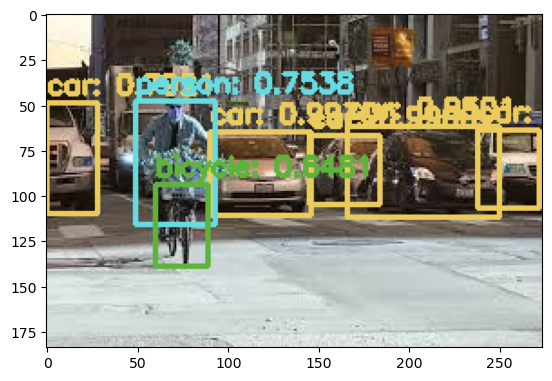

In [20]:
plt.imshow(image)
plt.show()